<a href="https://colab.research.google.com/github/Hramchenko/Handwritting/blob/master/ONE_SYMB_Copy_of_V11_of_EQ_no_prof_simpl_new_proffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

image_width = 1000
image_height = 200

In [0]:
import os
import cv2
from xml.dom import minidom
import matplotlib.pyplot as plt
from math import floor
from random import random
import scipy as sp


class ArtificialHandwrittingObject:
    
    def __init__(self, name, img):
        self.name = name
        self.image = img

class ArtificialHandwritting:
    
    def __init__(self, datasetDir, scale, image_width, image_height, encode_word):
        self.scale = scale
        self.height = image_height
        self.width = image_width
        self.datasetDirectory = datasetDir
        self.data = {}
        self.initOffsets()
        self.encode_word = encode_word
        
        for f_name in os.listdir(datasetDir):
            if not f_name.endswith(".xml"):
                continue
            full_path = datasetDir + f_name
            print(full_path)
            self.process_xml(full_path)
            
    def initOffsets(self):
        self.offsets = {
            'a': 0,
            'b': -0.1,
            'c': 0,
            'd': 0,
            'e': 0,
            'f': -0.2,
            'g': +0.3,
            'h': 0,
            'i': -0.15,
            'j': +0.2,
            'k': 0,
            'l': -0.15,
            'm': 0,
            'n': 0,
            'o': 0,
            'p': 0,
            'q': +0.2,
            'r': 0,
            's': 0,
            't': -0.2,
            'u': 0,
            'v': 0,
            'w': 0,
            'x': 0,
            'y': +0.2,
            'z': 0,
        }
        
        
        
    def getValue(self, node, name):
        v  = node.getElementsByTagName(name) 
        if len(v) != 1:
            raise Exception()
        v = v[0].firstChild.data
        return v
    
    def make_random_batch(self, word_len, rand_x):
        alphabet = "abcdefghijklmnopqrstuvwxyz"
        texts = []
        datas = []
        #data = torch.FloatTensor(batch_size, self.image_height, self.image_width)
        for batch_idx in range(0, batch_size):
          w = ""
          for i in range(0, word_len):
            s_idx = floor(random()*len(alphabet))
            s = alphabet[s_idx]
            w += s
          x = floor(random()*rand_x) + 10
          d, _ = self.make_word(w, x)
          d = d = torch.as_tensor(d)#.unsqueeze(0)
          
          datas.append(d)
          w = self.encode_word(w)
          texts.append(w)
        t = torch.stack(texts)
        data = torch.stack(datas, dim=0)
        return data, t
          
       
    def make_word(self, word, x_start):
        center = self.height*0.5
        result = sp.ones([self.height, self.width], dtype="float32")
        candidates = []
        for k in self.data.keys():
            d = self.data[k]
            flag = True
            for s in word:
                if s not in d:
                    flag = False
                    break
            if flag:
                candidates.append(k)
        idx = floor(random()*len(candidates))
        if (len(candidates) == 0):
          print("Bad word: " + word)
          raise Exception()
        
        img_file = candidates[idx]
        page = self.data[img_file]
        x = x_start
        for s in word:
            s_idx = floor(len(page[s])*random())
            obj_im = page[s][s_idx].image
            c = 0.5*obj_im.shape[0]
            dy = 0 + floor(center - c + obj_im.shape[0]*(self.offsets[s]+random()*0.05))#+random()*0.05))
            #print(dy)
            #print(obj_im.dtype)
            result[dy: dy + obj_im.shape[0], x: x+obj_im.shape[1]] = obj_im
            x += obj_im.shape[1]
        return result, img_file  
      
            
    def process_xml(self, f_path):
        
        xml_file = minidom.parse(f_path)
        #xml_file.normalize()
        annotation = xml_file.getElementsByTagName('annotation')
        if len(annotation) != 1:
            raise Exception()
        annotation = annotation[0]
        img_name = self.getValue(annotation, 'filename')
        image_file = self.datasetDirectory + img_name
        img = cv2.imread(image_file, 0)
        print(image_file)
        objects = annotation.getElementsByTagName('object')
        #print(len(objects))
        content = {}
        for obj in objects:
            name  = self.getValue(obj, 'name')
            if name not in content:
                content[name] = []
            x_min = int(self.getValue(obj, 'xmin'))
            y_min = int(self.getValue(obj, 'ymin'))
            x_max = int(self.getValue(obj, 'xmax'))
            y_max = int(self.getValue(obj, 'ymax'))
            obj_im = img[y_min: y_max, x_min: x_max]
            s = self.scale
            sh = obj_im.shape
            obj_im = cv2.resize(obj_im, (floor(sh[1]*s), floor(sh[0]*s)), cv2.INTER_LANCZOS4)
            if obj_im.shape[0] > self.height:
                continue
            obj_im = sp.float32(obj_im)    
            obj_im = (obj_im - obj_im.min())/(obj_im.max() - obj_im.min())
            handwr_obj = ArtificialHandwrittingObject(name, obj_im)
            content[name].append(handwr_obj)
        if img_name in self.data:
            raise Exception()
        self.data[img_name] = content
        

In [0]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords

pad_length=-1
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=400)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=400)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [0]:
artificial_data = ArtificialHandwritting("./MyLetters/", 1.0, image_width, image_height, train_set.encode_word)
data, target = artificial_data.make_random_batch(3, 400)

./MyLetters/a01-107u.xml
./MyLetters/a01-107u.png
./MyLetters/a01-026u.xml
./MyLetters/a01-026u.png
./MyLetters/my.xml
./MyLetters/my.jpg
./MyLetters/a01-053u.xml
./MyLetters/a01-053u.png
./MyLetters/a01-128.xml
./MyLetters/a01-128.png
./MyLetters/a01-107.xml
./MyLetters/a01-107.png


In [0]:
artificial_data.data["my.jpg"].keys()

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 't', 'v', 'w', 'x', 'y', 'z', 'j'])

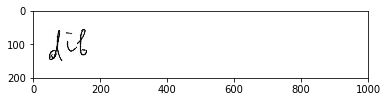

torch.Size([100, 200, 1000])

In [0]:
plt.imshow(data[0], cmap="gray")
plt.show()
data.shape

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
#!cat ./Handwritting/HTRDecoder.py


In [0]:
from Layers import *
#from HTREncoder import *
#from HTRDecoder import *
from HTRDiscriminator import *

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.unsqueeze(1).to(device)

In [0]:
def to_onehot(x, n):
    one_hot = torch.zeros((x.shape[0], n)).to(device)
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot  

In [0]:
class HTREncoder(nn.Module):
    def __init__(self, batchnorm=False, dropout=False):
        super(HTREncoder, self).__init__()
        
        self.convolutions = nn.Sequential(
        ConvLayer([1, 4, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([4, 16, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([16, 32, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([32, 64, 3], padding=0, stride=1, bn=batchnorm, pool_layer=None))
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None),
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None))
        
        #self.fc = FullyConnectedX([64*15*49, 64*49*3, 64*49], activation_fn=nn.ReLU())
    
    def forward(self, x):
        h = self.convolutions(x)

        h = F.max_pool2d(h, [h.size(0), 1], padding=[0, 0])

        
        
        h = h.squeeze(2)

        #h = h.flatten(start_dim=1)
        #h = self.fc(h)
        #h = F.max_pool2d(h, [1, h.size(1)], padding=[0, 0])
        #h = h.permute([2, 3, 0, 1])[0]
        #h = h.permute([2, 3, 0, 1])
        
        return h

In [0]:
encoder = HTREncoder().to(device)

In [0]:
c = encoder(data)
c.shape

torch.Size([100, 64, 122])

In [0]:
class HTRDecoderResult:
  
  def __init__(self):
    None

class HTRDecoder(nn.Module):
    def __init__(self, batch_size, ntoken, encoded_width=122, encoded_height=64, batchnorm=False, dropout=True, rnn_type="LSTM"):
        super(HTRDecoder, self).__init__()
        self.batch_size = batch_size
        self.ntoken = ntoken
        self.encoded_width = encoded_width
        self.encoded_height = encoded_height
        self.lstm_size = 256
        self.lstm_layers = 2
        self.rnn_type = rnn_type
        self.emb_size = 128
        features_size = self.encoded_height*encoded_width + self.emb_size
        from math import floor
        lstm_inp_size = features_size
        
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        else:
            self.rnn = nn.GRU(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        self.embedding = nn.Embedding(ntoken, self.emb_size)
        self.decoder = nn.Linear(1*self.lstm_size*1, ntoken)#*batch_size)
        self.drop = nn.Dropout(0.3)

        self.attention = FullyConnectedX([self.lstm_size*2 + self.encoded_height*encoded_width, self.encoded_height*encoded_width*2,  self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
        self.attention_weights = None
    
    def forward(self, x, prev, hidden=None):
        #x = self.drop(x).squeeze()
        x = x.squeeze()
        #print("xxxxxxxxxxxx")
        #print(x.shape)
        if hidden is not None:
            hidden_m = hidden.permute(1, 0, 2)
            hidden_m = hidden_m.flatten(start_dim=1)
            #print(x.shape)
            #print(hidden_m.shape)
            x_m = x.flatten(start_dim=1)
            attention_inp = torch.cat([x_m, hidden_m], dim=1).detach()
            #print(attention_inp.shape)
            #print(x.shape)
            
            self.attention_weights = self.attention(attention_inp)
            self.attention_weights = F.softmax(self.attention_weights, dim=1).unsqueeze(1)
            #print("iiiif")
            #print(self.attention_weights.shape)
            
            self.attention_weights = self.attention_weights.repeat([1, self.encoded_height, 1])
            #print("fffff")
            #print(x.shape)
            #print(self.attention_weights.shape)
            x = x * self.attention_weights
        emb = self.embedding(prev).squeeze().detach()
        x = torch.cat([x.flatten(start_dim=1), emb], dim=1)
        x = x.unsqueeze(0)
        result = HTRDecoderResult()
        result.rnn_input = x
        result.input_hidden = hidden
        x, hidden = self.rnn(x, hidden)
        x = x.squeeze(dim=0)
        #x = self.drop(x)
        x = self.decoder(x)
        x = F.log_softmax(x, dim=1)
        result.x = x
        result.hidden = hidden
        return result
      
    def makeHidden(self):
        if self.rnn_type == "LSTM":
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            h2 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return (h1, h2)
        else:
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return h1


decoder = HTRDecoder(batch_size, len(train_set.codes), rnn_type="GRU").to(device)

In [0]:
START = train_set.codes['<START>']
current_symbol = torch.LongTensor(batch_size, 1).to(device)
current_symbol[:, :] = START

In [0]:
def test(max_size):
  print("Testing...")
  
  freq = 20
  
  test_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  
  test_loss = 0
  
  with torch.no_grad():  
    while True:
      if batch_idx > 100:
        break

      if True:
        l = 1 + floor((max_size - 1)*random())
        data, target = artificial_data.make_random_batch(l, 5)
        orig_data = data;
        data = data.unsqueeze(1).to(device)
        target = target.to(device)  
      else:  
        batch = test_set.make_batch()
        if batch is None:
          break
        orig_data, target = batch
        data = orig_data/255.0
        #data = data.view(batch_size, 1, image_width, image_height).to(device)
        data = data.unsqueeze(1).to(device)
        target = target.to(device)
      hidden = decoder.makeHidden().to(device)    

      loss = 0
      enc = encoder(data)
      #print(enc.shape)
      s = enc
      #print(s.shape)
      #s = s.flatten(start_dim=1).view(1, batch_size, -1)

      old_symbol[:, 0] = START

      for i in range(0, target.shape[1]):

        decoder_result = decoder(s, old_symbol, hidden)
        dec = decoder_result.x
        hidden = decoder_result.hidden

        recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
        old_symbol[:, 0] = target[:, i]

        loss += criterion(dec, target[:, i])
      c_loss += loss.item()/(target.shape[1] + 0)
      test_loss += loss.item()/(target.shape[1] + 0)
      if (batch_idx % freq == 0) and (batch_idx != 0):
        if True:#not use_teacher_forcing:
          print(target.shape[0])
          for k in range(0, min(3, target.shape[0])):
              decoded = recognition_result[k,0:target.shape[1] + 1]
              plt.imshow(orig_data[k].cpu(), cmap="gray")
              plt.show()
              print("  '" + train_set.decode_word(target[k,:]) + "' -> '" + train_set.decode_word(decoded) + "'")
        c_loss /= freq 
        print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
        c_loss = 0
      batch_idx += 1  
  print("Test loss: %f" % (test_loss/batch_idx))   

In [0]:
discriminator = HTRDiscriminator(batch_size, 256*2, 512, 10, len(train_set.codes)).to(device)      

In [0]:
def apply_discriminator(s, target, use_teacher_forcing, train_mode, discriminator_target):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  train_mask = torch.ByteTensor(batch_size).to(device)
  train_mask[:] = 1

  hidden = decoder.makeHidden().to(device)    
  discriminator_loss = 0
  discriminator_hidden = discriminator.makeHidden().to(device)

  for i in range(0, target.shape[1] + 1):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    decoder_outputs = dec.topk(1, dim=1)[1].flatten()

    
    if train_mode:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden.detach(), decoder_result.input_hidden.detach(),decoder_result.rnn_input.detach(), decoder_outputs.detach(), discriminator_target)
    else:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden, decoder_result.input_hidden, decoder_result.rnn_input, decoder_outputs, discriminator_target)
      
    if i != 0:
      discriminator_loss += dl

    recognition_result[:, i] = decoder_outputs.detach()
    
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
    else:
      target_symbol = target[:, i]    
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += criterion(dec, target_symbol)
 
  discriminator_loss /= target.shape[1]
  return (recognition_result, loss, discriminator_loss)

In [0]:
def apply_decoder(s, target, use_teacher_forcing):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  hidden = decoder.makeHidden().to(device)  
  
  for i in range(0, target.shape[1] + 1):
    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
    
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
    else:
      target_symbol = target[:, i]
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += criterion(dec, target_symbol)
  return (recognition_result, loss)


batch_zeros = torch.zeros(batch_size, 1).to(device)
batch_ones = torch.ones(batch_size, 1).to(device)

In [0]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, weight_decay=0.00005)

#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

teacher_forcing_ratio = 1#0.5

from random import random

def train(epoch, max_size):
  print("Training epoch " + str(epoch) + "...")
  
  freq = 30
  
  train_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0

  
  train_loss = 0
  discr_applied = 0
  
  while True:
    if batch_idx > 400:
      break
    if True:
      l = 1 + floor((max_size - 1)*random())
      data, target = artificial_data.make_random_batch(l, 5)
      #data = data.unsqueeze(1).to(device)
      data = data.unsqueeze(1).to(device)
      #data = data.unsqueeze(1).to(device)
      target = target.to(device)
    else:
      batch = train_set.make_batch()
      if batch is None:
        break
      orig_data, target = batch
      data = orig_data/255.0
      #data = data.view(batch_size, 1, image_width, image_height).to(device)
      data = data.unsqueeze(1).to(device)
      target = target.to(device)


    encoder.zero_grad()
    decoder.zero_grad()

    
    enc = encoder(data)
    #print("xdddddddddddd")
    #print(data.shape)
    #print(enc.shape)
    s = enc
    #s = enc.permute(1, 0, 2)
    #s = s.squeeze(0)
    #print(s.shape)
    #print(s.shape)
    #s = s.flatten(start_dim=1).view(1, batch_size, -1)
    #s = s.flatten(start_dim=1).squeeze(0)
    #print("sssssssssssss")
    #print(s.shape)
    s = s.unsqueeze(0)
    
    discr_loss = 1
    if False: #True#target.shape[1] > 1:
      discriminator_optimizer.zero_grad()
      _, _, tf_loss = apply_discriminator(s, target, True, True, batch_ones)
      _, _, fr_loss = apply_discriminator(s, target, False, True, batch_zeros)
      dl = tf_loss + fr_loss
      discr_loss = dl.item()
      if (batch_idx % freq == 0) and (batch_idx != 0):
        print("Discr loss: %f" %(dl.item()))
      #print(dl)
      dl.backward()
      discriminator_optimizer.step()
   

      #     use_teacher_forcing = True if random() < teacher_forcing_ratio else False
      # #    recognition_result, loss, discriminator_loss = apply_discriminator(s, target, use_teacher_forcing, True, batch_zeros)
      #     recognition_result, loss = apply_decoder(s, target, use_teacher_forcing)
    batch_loss = None  
    if False:#discr_loss < 0.3:
      discriminator_optimizer.zero_grad()
      recognition_result, loss, discriminator_loss = apply_discriminator(s, target, True, False, batch_zeros)
      batch_loss = loss.item()
      loss = loss + discriminator_loss
      discr_applied += 1
      #print("Apply descr...")
    else:
      recognition_result, loss = apply_decoder(s, target, True)
      batch_loss = loss.item()

      
      
    c_loss += batch_loss/(target.shape[1] + 0)
    train_loss += batch_loss/(target.shape[1] + 0)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      
      if False:#True:#not use_teacher_forcing:
        for k in range(0, min(3, target.shape[0])):
            decoded = recognition_result[k,0:target.shape[1] + 1]
            plt.imshow(orig_data[k].cpu(), cmap="gray")
            plt.show()
            print("  '" + train_set.decode_word(target[k,:]) + "' -> '" + train_set.decode_word(decoded) + "'")
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    #grad_clip = 0.1
    #torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    #torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1
  print("Train loss: %f"%(train_loss/batch_idx))
  print("Discr applied %d times."%discr_applied)



In [0]:
file_name = "/gdrive/My Drive/v9.tar"

In [0]:
# state = torch.load(file_name)
# encoder.load_state_dict(state["encoder"])
# encoder_optimizer.load_state_dict(state["encoder_optimizer"])
# decoder.load_state_dict(state["decoder"])
# decoder_optimizer.load_state_dict(state["decoder_optimizer"])
# discriminator.load_state_dict(state["discriminator"])
# discriminator_optimizer.load_state_dict(state["discriminator_optimizer"])

Training epoch 0...
  Batch: 30 Loss: 8.405268239974976
  Batch: 60 Loss: 5.409993346532186
  Batch: 90 Loss: 4.193755849202474
  Batch: 120 Loss: 3.806393520037333
  Batch: 150 Loss: 3.57808575630188
  Batch: 180 Loss: 3.4345553795496624
  Batch: 210 Loss: 3.370612613360087
  Batch: 240 Loss: 3.332103443145752
  Batch: 270 Loss: 3.316101344426473
  Batch: 300 Loss: 3.30416202545166
  Batch: 330 Loss: 3.29939386844635
  Batch: 360 Loss: 3.2939167499542235
  Batch: 390 Loss: 3.289298144976298
Train loss: 3.974723
Discr applied 0 times.
Testing...
100


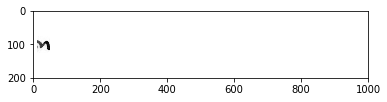

  'n' -> 'e<START>'


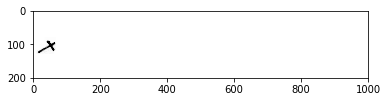

  'x' -> 'h<START>'


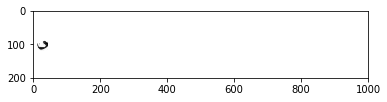

  'v' -> 'z<START>'
  Batch: 20 Loss: 3.443444538116455
100


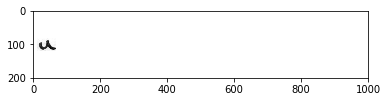

  'u' -> 'h<START>'


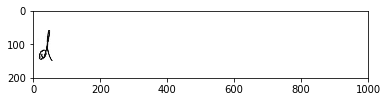

  'd' -> 'g<START>'


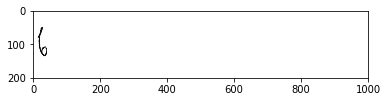

  'b' -> 'h<START>'
  Batch: 40 Loss: 3.280601692199707
100


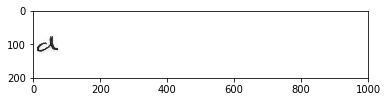

  'd' -> 'h<START>'


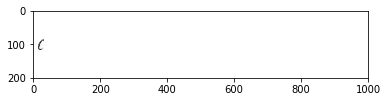

  'c' -> 'h<START>'


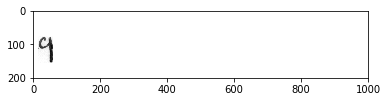

  'q' -> 'h<START>'
  Batch: 60 Loss: 3.279451584815979
100


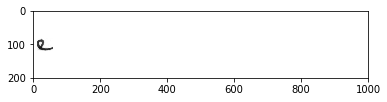

  'e' -> 'h<START>'


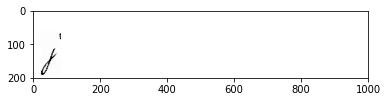

  'j' -> 'h<START>'


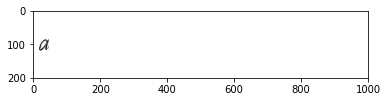

  'a' -> 'e<START>'
  Batch: 80 Loss: 3.2817071080207825
100


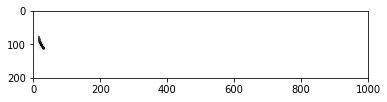

  'l' -> 'n<START>'


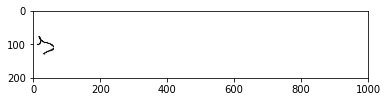

  's' -> 'h<START>'


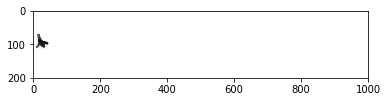

  't' -> 's<START>'
  Batch: 100 Loss: 3.2803542494773863
Test loss: 3.280309
Training epoch 1...
  Batch: 30 Loss: 3.39421645005544
  Batch: 60 Loss: 3.2826568524042767
  Batch: 90 Loss: 3.2798227707544965
  Batch: 120 Loss: 3.278995966911316
  Batch: 150 Loss: 3.2786572694778444
  Batch: 180 Loss: 3.278850793838501
  Batch: 210 Loss: 3.2767193714777627
  Batch: 240 Loss: 3.2735804080963136
  Batch: 270 Loss: 3.2734070936838786
  Batch: 300 Loss: 3.2715053002039594
  Batch: 330 Loss: 3.271389031410217
  Batch: 360 Loss: 3.2735230604807537
  Batch: 390 Loss: 3.2725119590759277
Train loss: 3.276471
Discr applied 0 times.
Testing...
100


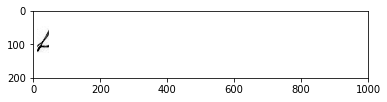

  't' -> 'p<START>'


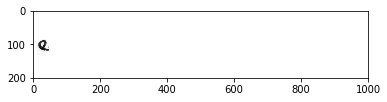

  'e' -> 'p<START>'


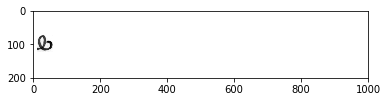

  'b' -> 'p<START>'
  Batch: 20 Loss: 3.4324900627136232
100


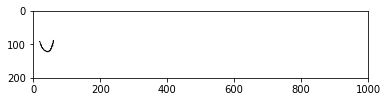

  'v' -> 'p<START>'


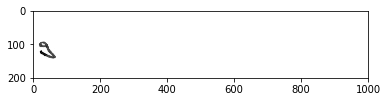

  'g' -> 'x<START>'


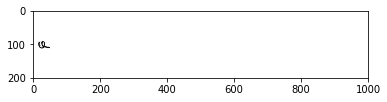

  'a' -> 'o<START>'
  Batch: 40 Loss: 3.270052671432495
100


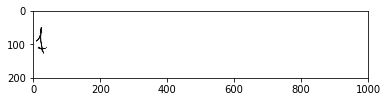

  'f' -> 'u<START>'


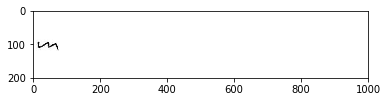

  'm' -> 'b<START>'


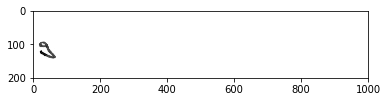

  'g' -> 'o<START>'
  Batch: 60 Loss: 3.270198380947113
100


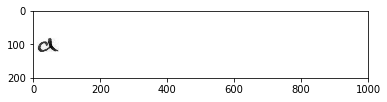

  'd' -> 'p<START>'


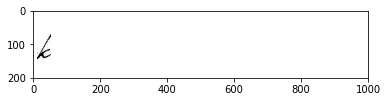

  'k' -> 'p<START>'


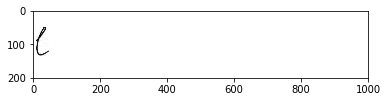

  'l' -> 'x<START>'
  Batch: 80 Loss: 3.2685261011123656
100


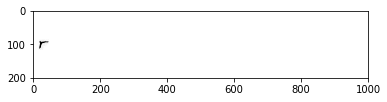

  'r' -> 'x<START>'


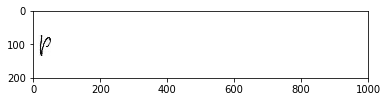

  'p' -> 'p<START>'


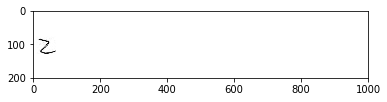

  'z' -> 'd<START>'
  Batch: 100 Loss: 3.270150065422058
Test loss: 3.269588
Training epoch 2...
  Batch: 30 Loss: 3.381628735860189
  Batch: 60 Loss: 3.2681977351506553
  Batch: 90 Loss: 3.2718003749847413
  Batch: 120 Loss: 3.2678751309712726
  Batch: 150 Loss: 3.2698253631591796
  Batch: 180 Loss: 3.265835920969645
  Batch: 210 Loss: 3.2703520615895587
  Batch: 240 Loss: 3.2682900031407676
  Batch: 270 Loss: 3.267219344774882
  Batch: 300 Loss: 3.266372068723043
  Batch: 330 Loss: 3.2696925083796184
  Batch: 360 Loss: 3.265036924680074
  Batch: 390 Loss: 3.265434678395589
Train loss: 3.268311
Discr applied 0 times.
Testing...
100


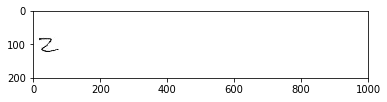

  'z' -> 'e<START>'


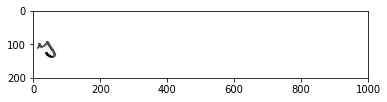

  'y' -> 's<START>'


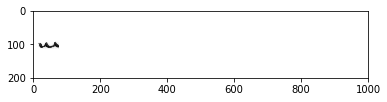

  'm' -> 'u<START>'
  Batch: 20 Loss: 3.43171466588974
100


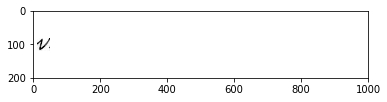

  'v' -> 'l<START>'


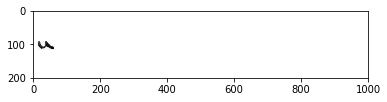

  'u' -> 'l<START>'


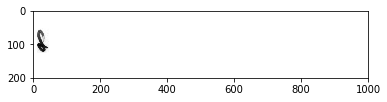

  'f' -> 'e<START>'
  Batch: 40 Loss: 3.2641743779182435
100


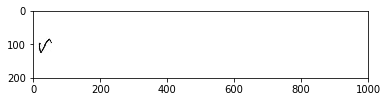

  'r' -> 's<START>'


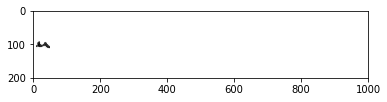

  'n' -> 'l<START>'


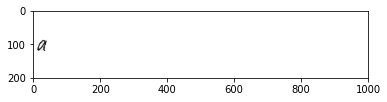

  'a' -> 's<START>'
  Batch: 60 Loss: 3.2655624747276306
100


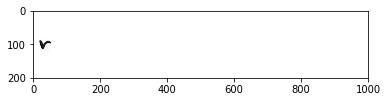

  'r' -> 'l<START>'


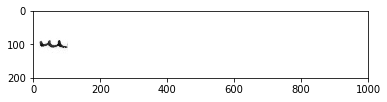

  'm' -> 'l<START>'


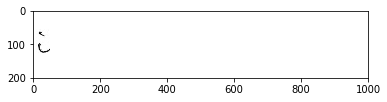

  'i' -> 'e<START>'
  Batch: 80 Loss: 3.2698533654212953
100


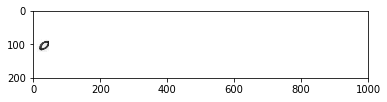

  'o' -> 'l<START>'


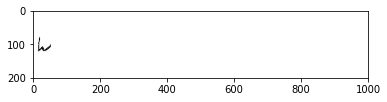

  'w' -> 'e<START>'


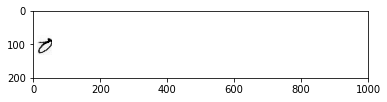

  'o' -> 'c<START>'
  Batch: 100 Loss: 3.2656248807907104
Test loss: 3.266719
Training epoch 3...
  Batch: 30 Loss: 3.3752081473668416
  Batch: 60 Loss: 3.2653175274531048
  Batch: 90 Loss: 3.2645267486572265
  Batch: 120 Loss: 3.266107694307963
  Batch: 150 Loss: 3.2642680486043294
  Batch: 180 Loss: 3.2651397148768107
  Batch: 210 Loss: 3.265053923924764
  Batch: 240 Loss: 3.2657154242197675
  Batch: 270 Loss: 3.2646722078323362
  Batch: 300 Loss: 3.266077740987142
  Batch: 330 Loss: 3.2648880958557127
  Batch: 360 Loss: 3.2631085952123007
  Batch: 390 Loss: 3.26628741423289
Train loss: 3.265195
Discr applied 0 times.
Testing...
100


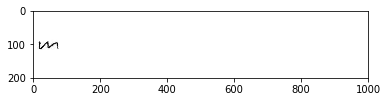

  'm' -> 'p<START>'


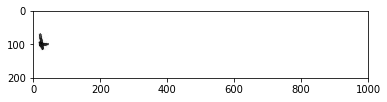

  't' -> 'r<START>'


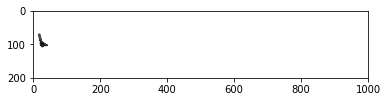

  't' -> 'x<START>'
  Batch: 20 Loss: 3.4236721277236937
100


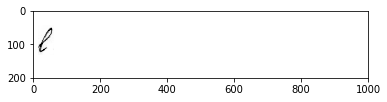

  'l' -> 'q<START>'


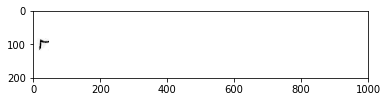

  'r' -> 'r<START>'


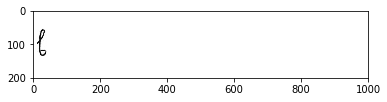

  'b' -> 'r<START>'
  Batch: 40 Loss: 3.2662104845046995
100


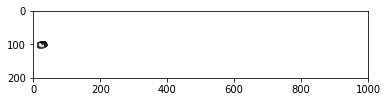

  'o' -> 'x<START>'


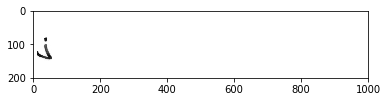

  'j' -> 't<START>'


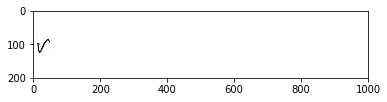

  'r' -> 'q<START>'
  Batch: 60 Loss: 3.2637070417404175
100


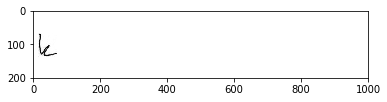

  'k' -> 'r<START>'


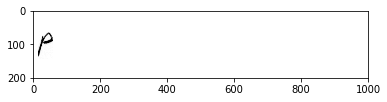

  'p' -> 'x<START>'


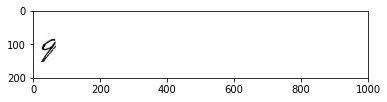

  'q' -> 'r<START>'
  Batch: 80 Loss: 3.2621151566505433
100


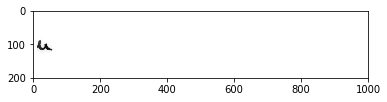

  'k' -> 'x<START>'


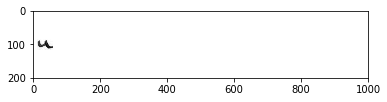

  'u' -> 'x<START>'


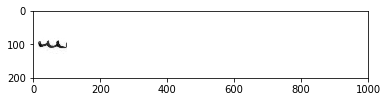

  'm' -> 'r<START>'
  Batch: 100 Loss: 3.2646702885627747
Test loss: 3.263441
Training epoch 4...
  Batch: 30 Loss: 3.372982621192932
  Batch: 60 Loss: 3.263167222340902
  Batch: 90 Loss: 3.2650619983673095
  Batch: 120 Loss: 3.2645508607228595
  Batch: 150 Loss: 3.262650728225708
  Batch: 180 Loss: 3.2625053405761717
  Batch: 210 Loss: 3.264976080258687
  Batch: 240 Loss: 3.265702716509501
  Batch: 270 Loss: 3.2620966752370197
  Batch: 300 Loss: 3.2644684314727783
  Batch: 330 Loss: 3.2622498830159503
  Batch: 360 Loss: 3.266194486618042
  Batch: 390 Loss: 3.2613949219385785
Train loss: 3.263772
Discr applied 0 times.
Testing...
100


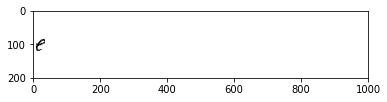

  'e' -> 'u<START>'


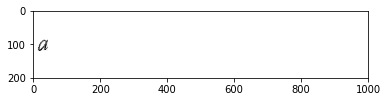

  'a' -> 'd<START>'


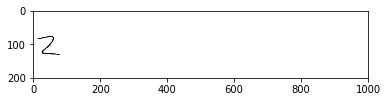

  'z' -> 'x<START>'
  Batch: 20 Loss: 3.42373126745224
100


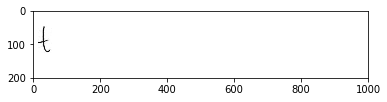

  't' -> 'u<START>'


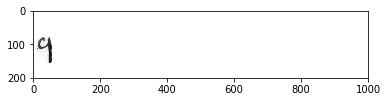

  'q' -> 'x<START>'


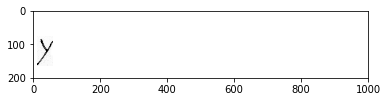

  'y' -> 'c<START>'
  Batch: 40 Loss: 3.260579490661621
100


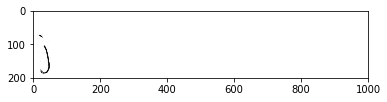

  'j' -> 'x<START>'


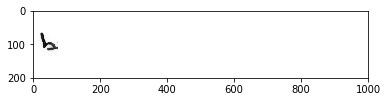

  'b' -> 'u<START>'


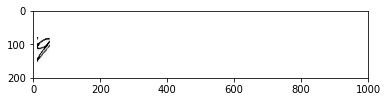

  'q' -> 'x<START>'
  Batch: 60 Loss: 3.2619233250617983
100


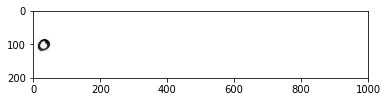

  'o' -> 'p<START>'


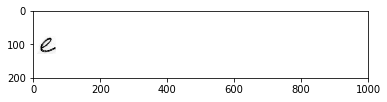

  'e' -> 'p<START>'


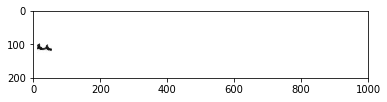

  'n' -> 'u<START>'
  Batch: 80 Loss: 3.2642601847648622
100


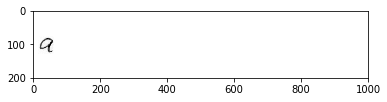

  'a' -> 'd<START>'


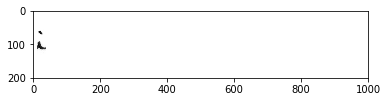

  'i' -> 'd<START>'


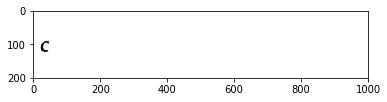

  'c' -> 'x<START>'
  Batch: 100 Loss: 3.2639036536216737
Test loss: 3.262257
Training epoch 5...
  Batch: 30 Loss: 3.3734182039896647
  Batch: 60 Loss: 3.2615960677464804
  Batch: 90 Loss: 3.2662798086802165
  Batch: 120 Loss: 3.2619836727778115
  Batch: 150 Loss: 3.2643304506937665
  Batch: 180 Loss: 3.263415805498759
  Batch: 210 Loss: 3.2657313426335652
  Batch: 240 Loss: 3.2644894043604533
  Batch: 270 Loss: 3.262879157066345
  Batch: 300 Loss: 3.263478930791219
  Batch: 330 Loss: 3.2632325649261475
  Batch: 360 Loss: 3.2621299743652346
  Batch: 390 Loss: 3.264776094754537
Train loss: 3.263749
Discr applied 0 times.
Testing...
100


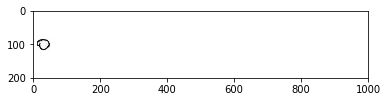

  'o' -> 'i<START>'


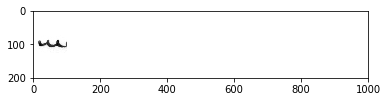

  'm' -> 'l<START>'


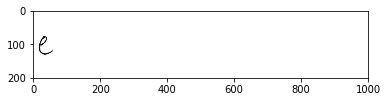

  'e' -> 'i<START>'
  Batch: 20 Loss: 3.4225615739822386
100


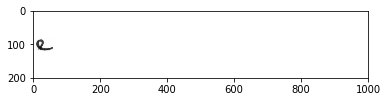

  'e' -> 'n<START>'


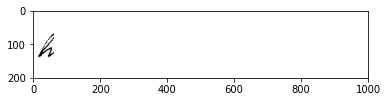

  'h' -> 'i<START>'


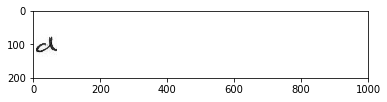

  'd' -> 'i<START>'
  Batch: 40 Loss: 3.2614394783973695
100


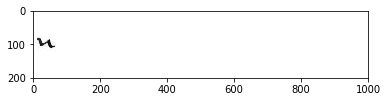

  'u' -> 'i<START>'


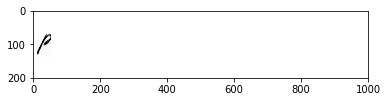

  'p' -> 'l<START>'


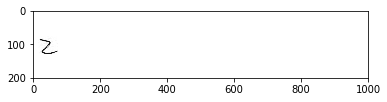

  'z' -> 'i<START>'
  Batch: 60 Loss: 3.263186991214752
100


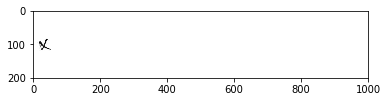

  'x' -> 'l<START>'


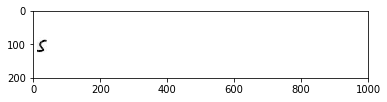

  's' -> 's<START>'


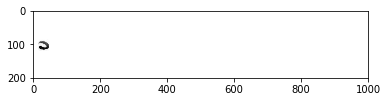

  's' -> 'l<START>'
  Batch: 80 Loss: 3.263327658176422
100


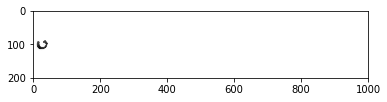

  'v' -> 'i<START>'


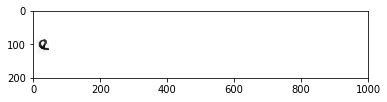

  'e' -> 'i<START>'


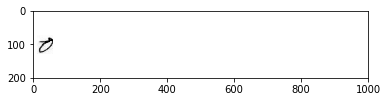

  'o' -> 'i<START>'
  Batch: 100 Loss: 3.258453166484833
Test loss: 3.261182
Training epoch 6...
  Batch: 30 Loss: 3.3716965198516844
  Batch: 60 Loss: 3.264000169436137
  Batch: 90 Loss: 3.2637919425964355
  Batch: 120 Loss: 3.264746824900309
  Batch: 150 Loss: 3.2634568293889363
  Batch: 180 Loss: 3.260195509592692
  Batch: 210 Loss: 3.2626028935114544
  Batch: 240 Loss: 3.26033771832784
  Batch: 270 Loss: 3.2622337341308594
  Batch: 300 Loss: 3.2630093653996783
  Batch: 330 Loss: 3.262400809923808
  Batch: 360 Loss: 3.261439402898153
  Batch: 390 Loss: 3.263087264696757
Train loss: 3.262740
Discr applied 0 times.
Testing...
100


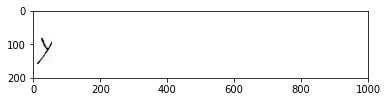

  'y' -> 'm<START>'


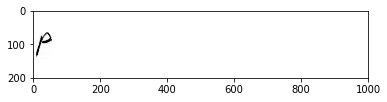

  'p' -> 'o<START>'


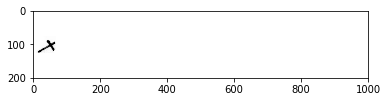

  'x' -> 'm<START>'
  Batch: 20 Loss: 3.4272319078445435
100


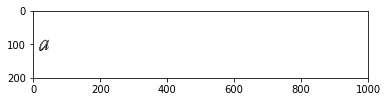

  'a' -> 'o<START>'


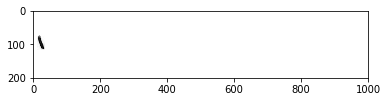

  'l' -> 'o<START>'


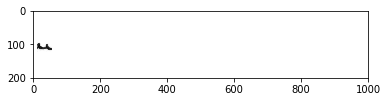

  'n' -> 'o<START>'
  Batch: 40 Loss: 3.2608840703964233
100


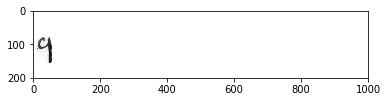

  'q' -> 'o<START>'


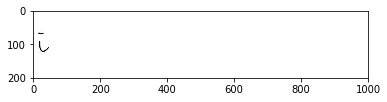

  'i' -> 'o<START>'


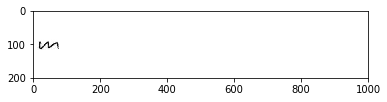

  'm' -> 'o<START>'
  Batch: 60 Loss: 3.262073850631714
100


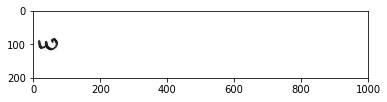

  'w' -> 'm<START>'


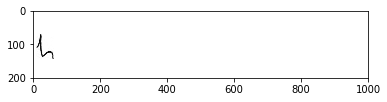

  'h' -> 'o<START>'


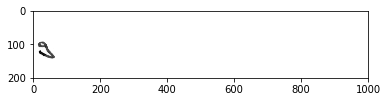

  'g' -> 'o<START>'
  Batch: 80 Loss: 3.2635417342185975
100


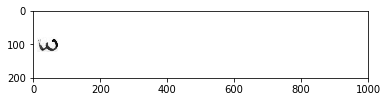

  'w' -> 'f<START>'


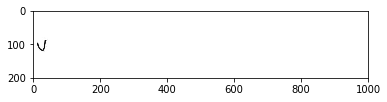

  'v' -> 'l<START>'


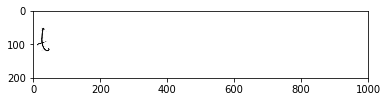

  't' -> 'o<START>'
  Batch: 100 Loss: 3.257546615600586
Test loss: 3.261639
Training epoch 7...
  Batch: 30 Loss: 3.369999082883199
  Batch: 60 Loss: 3.2609248717625934
  Batch: 90 Loss: 3.263230260213216
  Batch: 120 Loss: 3.262271197636922
  Batch: 150 Loss: 3.2632012526194254
  Batch: 180 Loss: 3.262198797861735
  Batch: 210 Loss: 3.2593430995941164
  Batch: 240 Loss: 3.2623759587605794
  Batch: 270 Loss: 3.2616910854975383
  Batch: 300 Loss: 3.2604676723480224
  Batch: 330 Loss: 3.26427804629008
  Batch: 360 Loss: 3.2608466863632204
  Batch: 390 Loss: 3.2612656275431315
Train loss: 3.261693
Discr applied 0 times.
Testing...
100


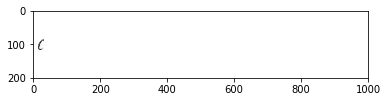

  'c' -> 'n<START>'


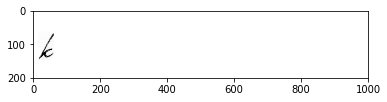

  'k' -> 'n<START>'


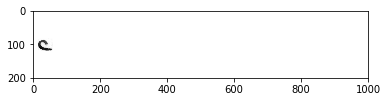

  'c' -> 'n<START>'
  Batch: 20 Loss: 3.4225368022918703
100


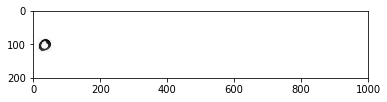

  'o' -> 'n<START>'


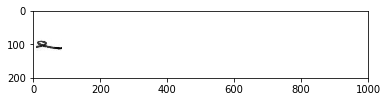

  'e' -> 'n<START>'


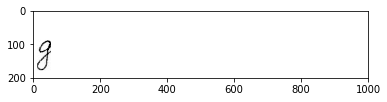

  'g' -> 'n<START>'
  Batch: 40 Loss: 3.263017416000366
100


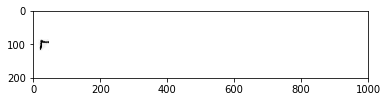

  'r' -> 'n<START>'


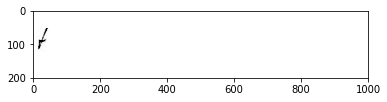

  't' -> 'r<START>'


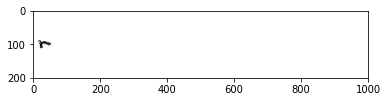

  'r' -> 'r<START>'
  Batch: 60 Loss: 3.261389636993408
100


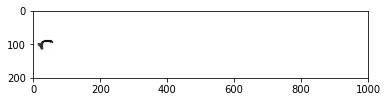

  'r' -> 'n<START>'


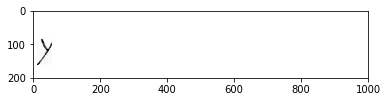

  'y' -> 'n<START>'


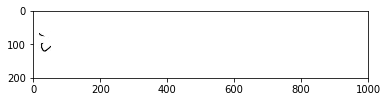

  'i' -> 'n<START>'
  Batch: 80 Loss: 3.262326157093048
100


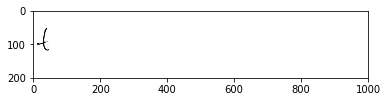

  't' -> 'n<START>'


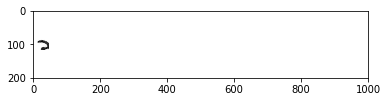

  's' -> 'r<START>'


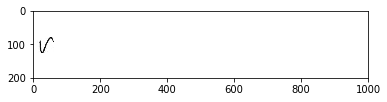

  'r' -> 'n<START>'
  Batch: 100 Loss: 3.2646611094474793
Test loss: 3.262165
Training epoch 8...
  Batch: 30 Loss: 3.3716333786646526
  Batch: 60 Loss: 3.262056827545166
  Batch: 90 Loss: 3.2613169034322103
  Batch: 120 Loss: 3.2588732481002807
  Batch: 150 Loss: 3.2437908331553142
  Batch: 180 Loss: 3.1415382862091064
  Batch: 210 Loss: 2.9338210423787436
  Batch: 240 Loss: 2.739064264297485
  Batch: 270 Loss: 2.5866973956425983
  Batch: 300 Loss: 2.632566976547241
  Batch: 330 Loss: 2.4811102708180743
  Batch: 360 Loss: 2.3809024651845294
  Batch: 390 Loss: 2.278180718421936
Train loss: 2.866464
Discr applied 0 times.
Testing...
100


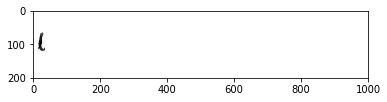

  'l' -> 'i<START>'


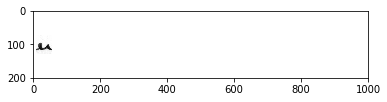

  'n' -> 'n<START>'


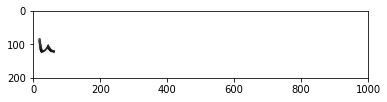

  'h' -> 'h<START>'
  Batch: 20 Loss: 2.325517773628235
100


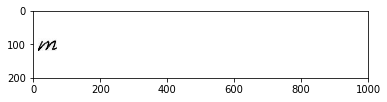

  'm' -> 'w<START>'


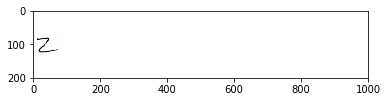

  'z' -> 'z<START>'


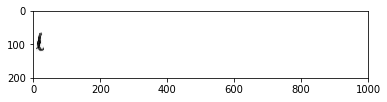

  'l' -> 'i<START>'
  Batch: 40 Loss: 2.253259336948395
100


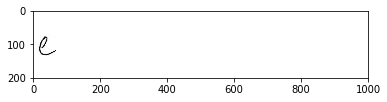

  'e' -> 'e<START>'


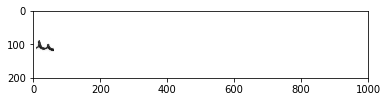

  'h' -> 'u<START>'


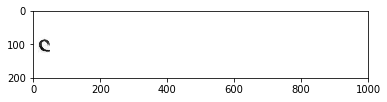

  'c' -> 'c<START>'
  Batch: 60 Loss: 2.2193864941596986
100


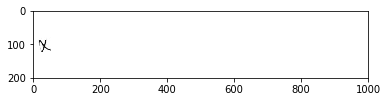

  'x' -> 's<START>'


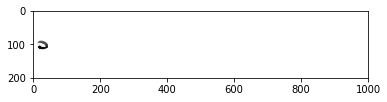

  's' -> 's<START>'


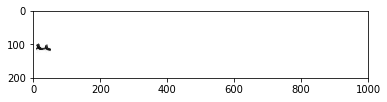

  'n' -> 'n<START>'
  Batch: 80 Loss: 2.2116764962673185
100


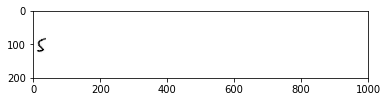

  's' -> 'i<START>'


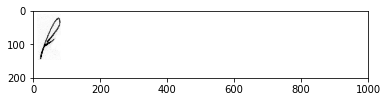

  'f' -> 'd<START>'


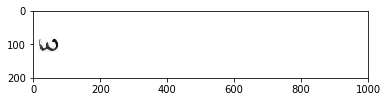

  'w' -> 'w<START>'
  Batch: 100 Loss: 2.21442688703537
Test loss: 2.222627
Training epoch 9...
  Batch: 30 Loss: 2.237170628706614
  Batch: 60 Loss: 2.1499224503835044
  Batch: 90 Loss: 2.0342857440312705
  Batch: 120 Loss: 2.010252217451731
  Batch: 150 Loss: 1.9343396504720052
  Batch: 180 Loss: 1.9078115224838257
  Batch: 210 Loss: 1.811726939678192
  Batch: 240 Loss: 1.7783523599306743
  Batch: 270 Loss: 1.7313641667366029
  Batch: 300 Loss: 1.7216641505559285
  Batch: 330 Loss: 1.674173883597056
  Batch: 360 Loss: 1.5866716623306274
  Batch: 390 Loss: 1.5571206251780192
Train loss: 1.843875
Discr applied 0 times.
Testing...
100


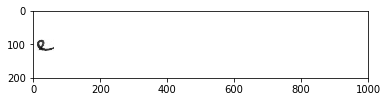

  'e' -> 'k<START>'


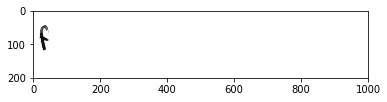

  'f' -> 'f<START>'


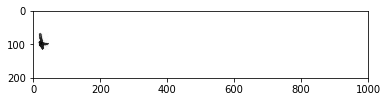

  't' -> 't<START>'
  Batch: 20 Loss: 1.6076632738113403
100


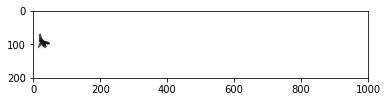

  't' -> 't<START>'


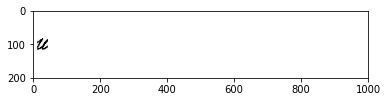

  'u' -> 's<START>'


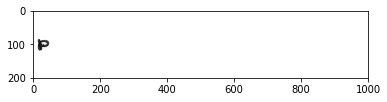

  'p' -> 'p<START>'
  Batch: 40 Loss: 1.5823438882827758
100


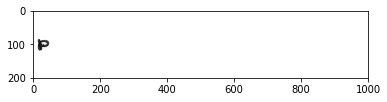

  'p' -> 'p<START>'


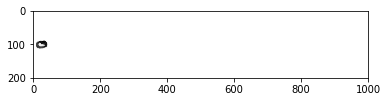

  'o' -> 'f<START>'


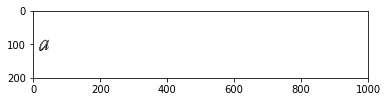

  'a' -> 'v<START>'
  Batch: 60 Loss: 1.5774637758731842
100


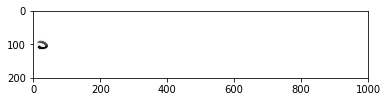

  's' -> 's<START>'


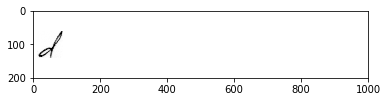

  'd' -> 'd<START>'


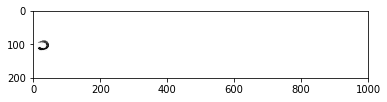

  's' -> 'o<START>'
  Batch: 80 Loss: 1.5125505208969117
100


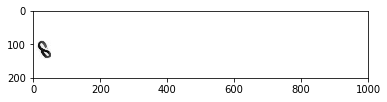

  'g' -> 'g<START>'


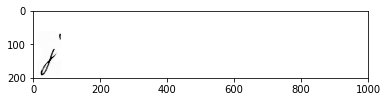

  'j' -> 'j<START>'


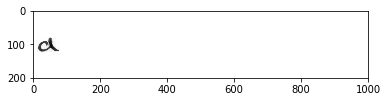

  'd' -> 'd<START>'
  Batch: 100 Loss: 1.5540865361690521
Test loss: 1.551309
Training epoch 10...
  Batch: 30 Loss: 1.5730908473332723
  Batch: 60 Loss: 1.60354532400767
  Batch: 90 Loss: 1.6360325415929158
  Batch: 120 Loss: 1.5134467323621115
  Batch: 150 Loss: 1.4537102858225504
  Batch: 180 Loss: 1.6185625553131104
  Batch: 210 Loss: 1.8101264397303263
  Batch: 240 Loss: 1.584482224782308
  Batch: 270 Loss: 1.467257591088613
  Batch: 300 Loss: 1.429969807465871
  Batch: 330 Loss: 1.3444462736447653
  Batch: 360 Loss: 1.2879931370417277
  Batch: 390 Loss: 1.2576128443082173
Train loss: 1.495591
Discr applied 0 times.
Testing...
100


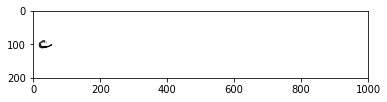

  'c' -> 'c<START>'


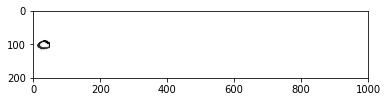

  'o' -> 'o<START>'


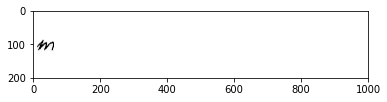

  'm' -> 'm<START>'
  Batch: 20 Loss: 1.244824394583702
100


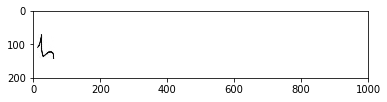

  'h' -> 'h<START>'


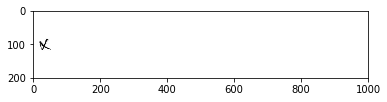

  'x' -> 'x<START>'


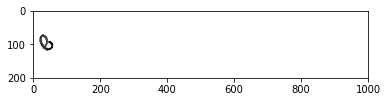

  'b' -> 'b<START>'
  Batch: 40 Loss: 1.2637323677539825
100


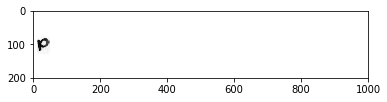

  'p' -> 'p<START>'


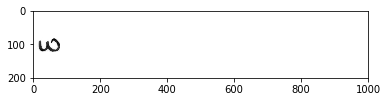

  'w' -> 'w<START>'


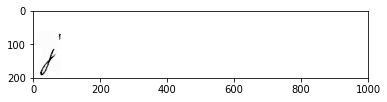

  'j' -> 'j<START>'
  Batch: 60 Loss: 1.235110354423523
100


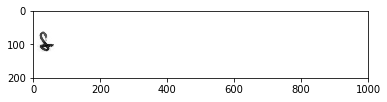

  'f' -> 'f<START>'


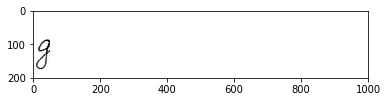

  'g' -> 'y<START>'


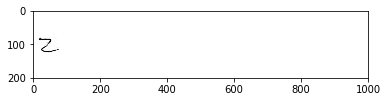

  'z' -> 'z<START>'
  Batch: 80 Loss: 1.2218502372503282
100


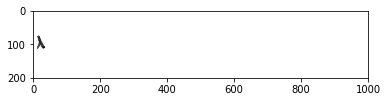

  'l' -> 'l<START>'


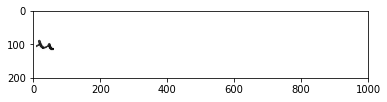

  'h' -> 'h<START>'


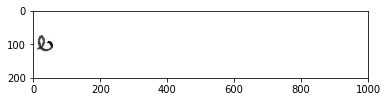

  'b' -> 'b<START>'
  Batch: 100 Loss: 1.2764387905597687
Test loss: 1.236031
Training epoch 11...
  Batch: 30 Loss: 1.2708245913187664
  Batch: 60 Loss: 1.1732110182444255
  Batch: 90 Loss: 1.1679659605026245
  Batch: 120 Loss: 1.1385973890622456
  Batch: 150 Loss: 1.1250658313433328
  Batch: 180 Loss: 1.0586103280385335
  Batch: 210 Loss: 1.0200912356376648
  Batch: 240 Loss: 1.0167383631070455
  Batch: 270 Loss: 0.9472857733567556
  Batch: 300 Loss: 0.9516109724839529
  Batch: 330 Loss: 0.931574277083079
  Batch: 360 Loss: 0.8806417485078176
  Batch: 390 Loss: 0.8547185659408569
Train loss: 1.034177
Discr applied 0 times.
Testing...
100


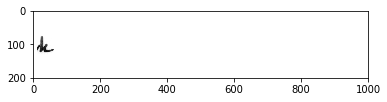

  'k' -> 'k<START>'


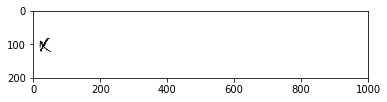

  'x' -> 'x<START>'


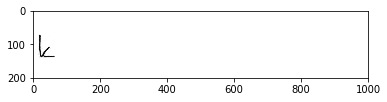

  'k' -> 'k<START>'
  Batch: 20 Loss: 0.9032398372888565
100


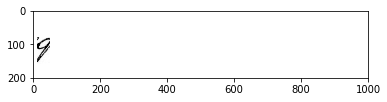

  'q' -> 'q<START>'


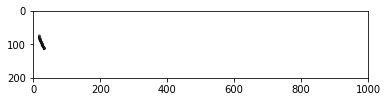

  'l' -> 'l<START>'


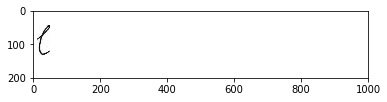

  'l' -> 't<START>'
  Batch: 40 Loss: 0.8470080435276032
100


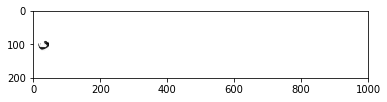

  'v' -> 's<START>'


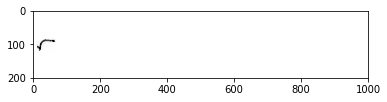

  'r' -> 'r<START>'


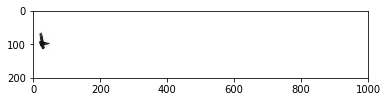

  't' -> 't<START>'
  Batch: 60 Loss: 0.844152358174324
100


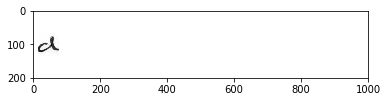

  'd' -> 'd<START>'


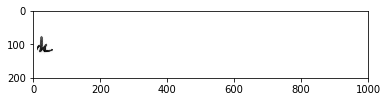

  'k' -> 'k<START>'


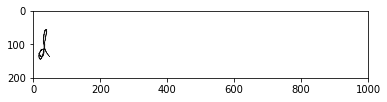

  'd' -> 'f<START>'
  Batch: 80 Loss: 0.8383131206035614
100


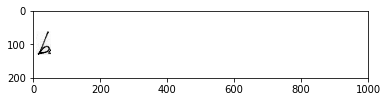

  'b' -> 'b<START>'


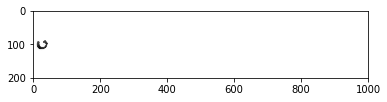

  'v' -> 'v<START>'


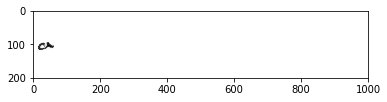

  'a' -> 'a<START>'
  Batch: 100 Loss: 0.8481320738792419
Test loss: 0.847692
Training epoch 12...
  Batch: 30 Loss: 0.8751061201095581
  Batch: 60 Loss: 0.813147783279419
  Batch: 90 Loss: 0.8036330461502075
  Batch: 120 Loss: 0.7490800937016805
  Batch: 150 Loss: 0.7579141219456991
  Batch: 180 Loss: 0.7258228937784831
  Batch: 210 Loss: 0.7023254613081614
  Batch: 240 Loss: 0.7145440836747488
  Batch: 270 Loss: 0.654486009478569
  Batch: 300 Loss: 0.656781421105067
  Batch: 330 Loss: 0.6133359213670094
  Batch: 360 Loss: 0.626994447906812
  Batch: 390 Loss: 0.6093619793653489
Train loss: 0.711094
Discr applied 0 times.
Testing...
100


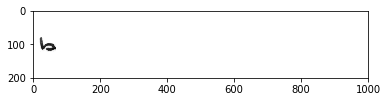

  'b' -> 'b<START>'


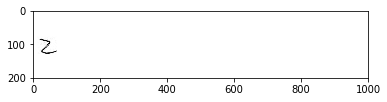

  'z' -> 'z<START>'


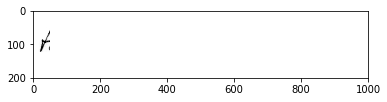

  't' -> 'f<START>'
  Batch: 20 Loss: 0.5971350222826004
100


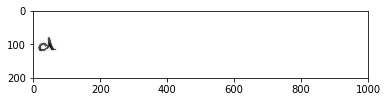

  'd' -> 'd<START>'


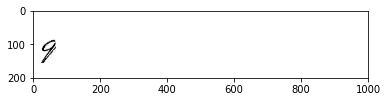

  'q' -> 'q<START>'


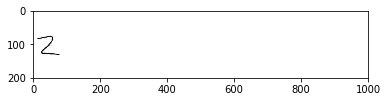

  'z' -> 'z<START>'
  Batch: 40 Loss: 0.5683363258838654
100


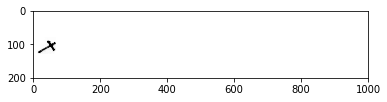

  'x' -> 'x<START>'


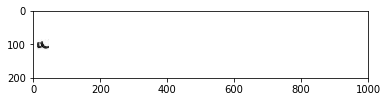

  'u' -> 'u<START>'


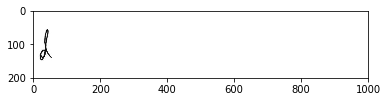

  'd' -> 'd<START>'
  Batch: 60 Loss: 0.5861320808529854
100


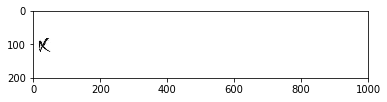

  'x' -> 'x<START>'


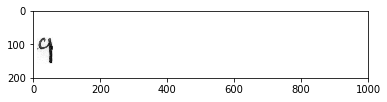

  'q' -> 'q<START>'


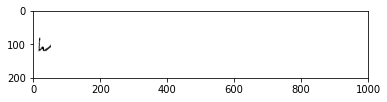

  'w' -> 'w<START>'
  Batch: 80 Loss: 0.5637493386864663
100


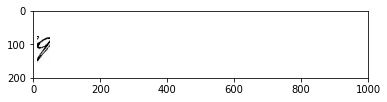

  'q' -> 'q<START>'


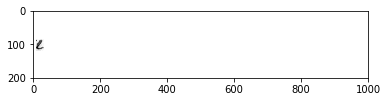

  'e' -> 'i<START>'


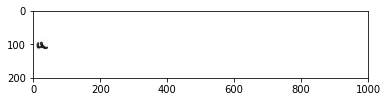

  'u' -> 'u<START>'
  Batch: 100 Loss: 0.5600406467914582
Test loss: 0.569385
Training epoch 13...
  Batch: 30 Loss: 0.6019432117541631
  Batch: 60 Loss: 0.5681085377931595
  Batch: 90 Loss: 0.5504972219467164
  Batch: 120 Loss: 0.5310297936201096
  Batch: 150 Loss: 0.5053327639897665
  Batch: 180 Loss: 0.49347375830014545
  Batch: 210 Loss: 0.48796052833398185
  Batch: 240 Loss: 0.4479489336411158
  Batch: 270 Loss: 0.43776198426882423
  Batch: 300 Loss: 0.4450834850470225
  Batch: 330 Loss: 0.42662823498249053
  Batch: 360 Loss: 0.4202602684497833
  Batch: 390 Loss: 0.38577362497647605
Train loss: 0.481072
Discr applied 0 times.
Testing...
100


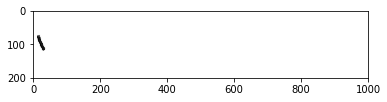

  'l' -> 'l<START>'


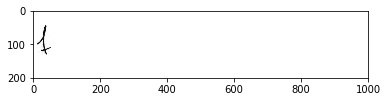

  'f' -> 'f<START>'


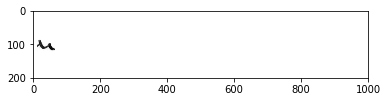

  'h' -> 'h<START>'
  Batch: 20 Loss: 0.40797058343887327
100


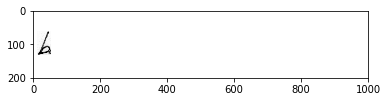

  'b' -> 'b<START>'


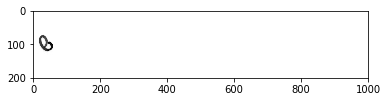

  'b' -> 'b<START>'


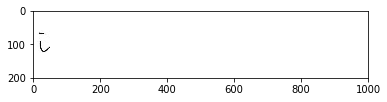

  'i' -> 'i<START>'
  Batch: 40 Loss: 0.3988765046000481
100


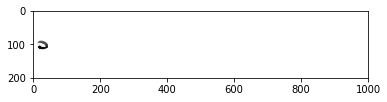

  's' -> 's<START>'


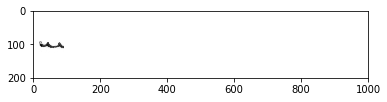

  'm' -> 'm<START>'


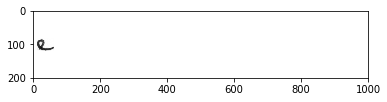

  'e' -> 'e<START>'
  Batch: 60 Loss: 0.4034528449177742
100


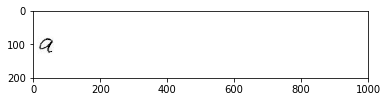

  'a' -> 'a<START>'


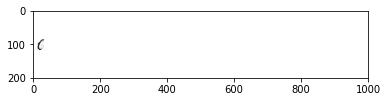

  'c' -> 'c<START>'


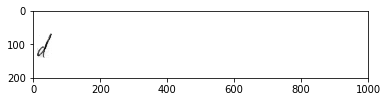

  'd' -> 'd<START>'
  Batch: 80 Loss: 0.37485224306583403
100


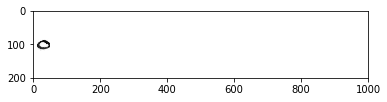

  'o' -> 'o<START>'


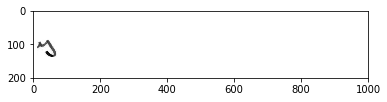

  'y' -> 'y<START>'


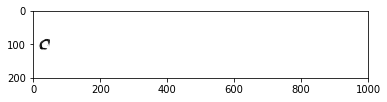

  'c' -> 'p<START>'
  Batch: 100 Loss: 0.3990353882312775
Test loss: 0.392908
Training epoch 14...
  Batch: 30 Loss: 0.3904658575852712


KeyboardInterrupt: ignored

In [0]:
for i in range(0, 100):
  max_size = 1
  train(i, max_size)
  test(max_size)

In [0]:
test(1)

In [0]:
# state_dict = {
#         "encoder": encoder.state_dict(),
#         "encoder_optimizer": encoder_optimizer.state_dict(),
#         "decoder": decoder.state_dict(),
#         "decoder_optimizer": decoder_optimizer.state_dict(),
#         "discriminator": discriminator.state_dict(),
#         "discriminator_optimizer": discriminator_optimizer.state_dict(),
#       }

# torch.save(state_dict, file_name)


In [0]:
test(2)

In [0]:
data, target = artificial_data.make_random_batch(3, 200)

In [0]:
for i in range(0, 30):
  plt.imshow(data[i])
  plt.show()
  print(test_set.decode_word(target[i]))